Active contour different implementations and test on hand image 

In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from itertools import combinations
from collections import defaultdict
import cv2

# Add the path to the directory containing the 'classes' module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# from classes.edge_detector import EdgeDetector
# from classes.frequency_processor import FrequencyProcessor
# from classes.histogram_processor import HistogramProcessor
# from utils import *

In [4]:
# D:\SBME\3rd Year\CV\Tasks\LucidumLab\Task1-Noisy-Visions-Filtering-and-Edge-Perception\pyQt\data\hand_image_2.jpg
fist_path = '../data/hand_image_2.jpg'
pinky_up_path = '../data/hand_image.jpg'

In [5]:
fist_image = cv2.imread(fist_path, cv2.COLOR_BGR2RGB)
pinky_up_image = cv2.imread(pinky_up_path,  cv2.COLOR_BGR2RGB)

fist_image_gray = cv2.cvtColor(fist_image, cv2.COLOR_RGB2GRAY)
pinky_up_image_gray = cv2.cvtColor(pinky_up_image, cv2.COLOR_RGB2GRAY)



First implementations 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def initialize_snake(center, radius, points=100):
    """Create a circular snake around a given center with a specific radius."""
    s = np.linspace(0, 2 * np.pi, points)
    x = center[0] + radius * np.cos(s)
    y = center[1] + radius * np.sin(s)
    return np.array([x, y]).T

def internal_energy_matrix(n_points, alpha=0.1, beta=0.1, gamma=0.1):
    """Create the internal energy matrix A for smoothness and elasticity."""
    A = np.zeros((n_points, n_points))
    for i in range(n_points):
        A[i, i] = 2 * alpha + 6 * beta
        A[i, (i - 1) % n_points] = -alpha - 4 * beta
        A[i, (i + 1) % n_points] = -alpha - 4 * beta
        A[i, (i - 2) % n_points] = beta
        A[i, (i + 2) % n_points] = beta
    return np.linalg.inv(A + gamma * np.eye(n_points))

def external_energy(image, sigma=1.0):
    """Compute the edge energy from the image gradient."""
    smoothed_image = gaussian_filter(image, sigma)
    gy, gx = np.gradient(smoothed_image)
    edge_energy = np.sqrt(gx**2 + gy**2)
    # Normalize gradients
    gx = gx / np.max(np.abs(gx))
    gy = gy / np.max(np.abs(gy))
    return edge_energy, gx, gy

def optimize_snake(image, snake, inv_matrix, gx, gy, 
                   gamma=0.1, w_edge=1.0, iterations=250, convergence=0.01):
    """Iteratively optimize the snake's position."""
    for iter_num in range(iterations):
        # print(f"Iteration {iter_num + 1}/{iterations}")
        
        # Interpolate external forces at snake points
        int_x = np.clip(snake[:, 0].astype(int), 0, image.shape[1] - 1)
        int_y = np.clip(snake[:, 1].astype(int), 0, image.shape[0] - 1)
        
        fx = gx[int_y, int_x]
        fy = gy[int_y, int_x]
        
        # Normalize external forces
        force_magnitude = np.sqrt(fx**2 + fy**2)
        force_magnitude[force_magnitude == 0] = 1  # Avoid division by zero
        # fx = fx / force_magnitude
        # fy = fy / force_magnitude
        
        # External force vector
        force = np.stack([fx, fy], axis=1) * w_edge
        print("force",force.shape)
        # Update snake using internal and external forces
        new_snake = np.dot(inv_matrix, snake + gamma * force)
        
        # Ensure snake points stay within image boundaries
        new_snake[:, 0] = np.clip(new_snake[:, 0], 0, image.shape[1] - 1)
        new_snake[:, 1] = np.clip(new_snake[:, 1], 0, image.shape[0] - 1)
        
        # Debugging: Check for NaN values
        if np.isnan(new_snake).any():
            print(f"Iteration {iter_num}: NaN values encountered in new_snake: {new_snake}")
            break
        
        # Convergence check
        displacement = np.mean(np.sqrt(np.sum((new_snake - snake) ** 2, axis=1)))
        # print(f"Average displacement: {displacement}")
        if displacement < convergence:
            print("Convergence reached.")
            
            break
        
        snake = new_snake
        
    return snake

def active_contour(image, center, radius, alpha=0.1, beta=0.1, gamma=0, 
                   w_edge=1.0, sigma=1.0, iterations=250, convergence=0.01, points=100):
    """High-level function to initialize and run active contour optimization."""
    snake = initialize_snake(center, radius, points)
    print(snake.shape)
    inv_matrix = internal_energy_matrix(len(snake), alpha, beta, gamma)
    print(inv_matrix.shape)
    edge_energy, gx, gy = external_energy(image, sigma)
    snake = optimize_snake(image, snake, inv_matrix, gx, gy, 
                           gamma, w_edge, iterations, convergence)
    return snake

(70, 2)
(70, 70)
force (70, 2)
force (70, 2)
Convergence reached.


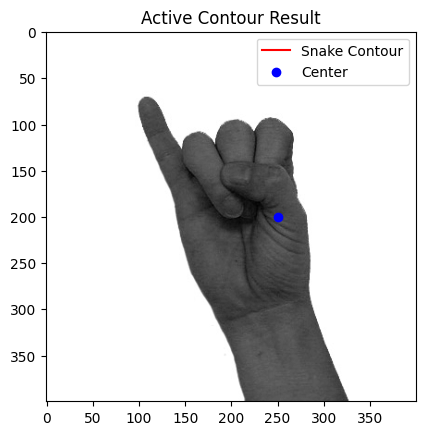

In [21]:
center = (250, 200)
radius = 200
# for i in range (2, 10):
    # print(f"Number of alpha and beta: {i*1000}")
snake = active_contour(pinky_up_image_gray, center, radius, alpha=.1, beta=.5, gamma=0.001, 
                    w_edge=10, sigma=1.4, iterations=1000, convergence=0.0001, points=70)

plt.imshow(pinky_up_image_gray, cmap='gray')
plt.plot(snake[:, 0], snake[:, 1], 'r-', label="Snake Contour")
plt.scatter(center[0], center[1], color='blue', label="Center")
plt.title("Active Contour Result")
plt.legend()
plt.show()